## NLP for News Website Articles Topic Modelling

The scrapper contained in the folder will crawl the web by parsing a csv file with urls. The scrapper will provide us with a csv file containing the url,website title and description for each url in the original csv. 
For this project, we obtained a list of urls to articles' websites. This notebook performs NLP on the output dataset from the scrapper, and consists of:

1) Topic Modelling with LDA:

- Aimed at constructing a good dictionary by extracting all possible vocabularies/words from the dataset and remove those that are not relevant/informative (e.g., the infrequent words). 

- For url, given "www.lachainemeteo.com/meteo-france/ville-6560/previsions-meteo-bordeaux-aujourdhui" the following words can be extracted: lachainemeteo (or www.lachainemeteo.com), meteo-france, ville, prevision, meteo, bordeaux.

- Built a first/baseline model/method using LDA (Latent Dirichlet Allocation from the Gensim library) to find the topics from the constructed dictionary. An important aspect is properly defining the number of topics for LDA.

- Applied LDA to both titles and descriptions of the websites seperately. Finally, we combine all columns containing description, title and url to construct the dictionary and apply LDA. We then minimize topic coherence metrics vs. Topics number in LDA to find the best number of topics

2) Improving Baseline model:

To find the best number of topics, we have used two methods:
    - Calculated topic coherence for several number of topics to obtain optimal number of topics
    - Clustered embedding with K-means and used the elbow method to find optimal number of clusters

- For titles, used LSA to obtain SVD_matrix, performed k-means clustering on vectors representations, and applied LDA on each cluster to define 1 topic per cluster 

- For descriptions, implemented word2vec, performed k-means clustering on vectors representations, applied TF/IDF and other preprocessing techniques to keep only useful words (specially for descriptions), and applied LDA on each cluster to define 1 topic per cluster 


In [1]:
#Preprocessing URL data and creating data2.csv
import pandas as pd

df = pd.read_csv("scrapy_url/scrapped_url.csv", delimiter=",")
df = df.dropna(subset=['title', 'description']).drop(columns="Unnamed: 3")

for i in range(0,len(df)):
    # taking care of www., .com, http and https.. and tokenizing
    if df.iloc[i,0][4]=="s":
        df.iloc[i,0] = str(df.iloc[i,0][8:]).replace("www.","").replace(".comment",". comment").replace(".madame",". madame").replace(".com","").replace(".php","").replace(".fr","").replace(".html","").replace("."," ").replace("-"," ").replace("0","").replace("1","").replace("2","").replace("3","").replace("4","").replace("5","").replace("6","").replace("7","").replace("8","").replace("9","").strip().split("/")
        df.iloc[i,0] = str(" ".join(df.iloc[i,0]).strip().replace("     "," ").replace("  "," ").lower().replace(" artfig","")).split(" ")
    else:
        df.iloc[i,0] = str(df.iloc[i,0][7:]).replace("www.","").replace(".comment",". comment").replace(".madame",". madame").replace(".com","").replace(".php","").replace(".fr","").replace(".html","").replace("."," ").replace("-"," ").replace("0","").replace("1","").replace("2","").replace("3","").replace("4","").replace("5","").replace("6","").replace("7","").replace("8","").replace("9","").strip().split("/")
        df.iloc[i,0] = str(" ".join(df.iloc[i,0]).strip().replace("     "," ").replace("  "," ").lower().replace(" artfig","")).split(" ")

df.to_csv("data2.csv")

### Baseline Model: Analysing URLs with LDA

In [2]:
import gensim
import pandas as pd
from gensim import corpora
import pickle

df = pd.read_csv("data2.csv")
unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute"]

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in unallowed_words:
            result.append(token)
    return result

processed_url = df['url_clean'].map(preprocess)
processed_url

dictionary = corpora.Dictionary(processed_url)
corpus = [dictionary.doc2bow(text) for text in processed_url]

#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save(f"model{NUM_TOPICS}.gensim")

In [3]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.120*"forum" + 0.117*"affich" + 0.032*"comment" + 0.027*"finances" + 0.027*"droit" + 0.011*"pour" + 0.011*"bricolage" + 0.010*"faire" + 0.008*"votre" + 0.008*"cuisiner"
Topic: 1 
Words: 0.056*"meteo" + 0.031*"ville" + 0.026*"previsions" + 0.025*"france" + 0.024*"ticketac" + 0.024*"aujourdhui" + 0.019*"cinema" + 0.019*"hugolescargot" + 0.018*"spectacles" + 0.018*"news"
Topic: 2 
Words: 0.071*"madame" + 0.061*"sport" + 0.030*"celebrites" + 0.025*"societe" + 0.021*"scan" + 0.021*"actualite" + 0.018*"bien" + 0.015*"etre" + 0.014*"photos" + 0.011*"pour"
Topic: 3 
Words: 0.032*"article" + 0.031*"madame" + 0.030*"style" + 0.029*"pour" + 0.028*"conseils" + 0.019*"editorial" + 0.019*"cadremploi" + 0.018*"deco" + 0.017*"beaute" + 0.014*"finances"
Topic: 4 
Words: 0.035*"meghan" + 0.031*"markle" + 0.012*"mort" + 0.010*"dans" + 0.010*"deux" + 0.009*"chocolat" + 0.009*"voyage" + 0.007*"examens" + 0.006*"tennis" + 0.006*"pourquoi"
Topic: 5 
Words: 0.065*"cuisine" + 0.060*"madame" +

In [4]:
topics = ldamodel.print_topics(num_words=1)
for topic in topics:
    print(topic)

(0, '0.120*"forum"')
(1, '0.056*"meteo"')
(2, '0.071*"madame"')
(3, '0.032*"article"')
(4, '0.035*"meghan"')
(5, '0.065*"cuisine"')
(6, '0.072*"video"')
(7, '0.126*"sante"')
(8, '0.028*"television"')


## Baseline Model: Analysing Titles with LDA

In [5]:
import gensim
import pandas as pd
from gensim import corpora
import pickle

df = pd.read_csv("data2.csv")
unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute","internaute","madame"]

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 4 and token not in unallowed_words:
            result.append(token)
    return result

processed_url = df['title'].map(preprocess)
processed_url

dictionary = corpora.Dictionary(processed_url)
corpus = [dictionary.doc2bow(text) for text in processed_url]

#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save(f"model{NUM_TOPICS}.gensim")

In [6]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.134*"recette" + 0.057*"cuisine" + 0.038*"facile" + 0.016*"meilleure" + 0.013*"maison" + 0.012*"idées" + 0.008*"prénoms" + 0.007*"pommes" + 0.007*"digital" + 0.007*"kiosque"
Topic: 1 
Words: 0.055*"actualité" + 0.055*"sport" + 0.054*"temps" + 0.048*"sportive" + 0.020*"résultat" + 0.018*"résolu" + 0.014*"tirage" + 0.010*"quand" + 0.009*"ligne" + 0.008*"euros"
Topic: 2 
Words: 0.068*"résolu" + 0.039*"santé" + 0.037*"médecine" + 0.015*"théâtre" + 0.015*"comment" + 0.011*"contre" + 0.008*"cannes" + 0.008*"vente" + 0.008*"appartements" + 0.008*"nouveau"
Topic: 3 
Words: 0.026*"faire" + 0.020*"comment" + 0.019*"résolu" + 0.016*"monde" + 0.015*"conjugaison" + 0.014*"verbe" + 0.012*"macron" + 0.012*"promo" + 0.010*"people" + 0.009*"match"
Topic: 4 
Words: 0.023*"résolu" + 0.019*"lettre" + 0.014*"comment" + 0.013*"modèle" + 0.013*"hallyday" + 0.012*"femme" + 0.011*"gratuit" + 0.011*"johnny" + 0.010*"logement" + 0.008*"découvrez"
Topic: 5 
Words: 0.027*"conseils" + 0.026*"comme

In [7]:
topics = ldamodel.print_topics(num_words=1)
for topic in topics:
    print(topic)

(0, '0.134*"recette"')
(1, '0.055*"actualité"')
(2, '0.068*"résolu"')
(3, '0.026*"faire"')
(4, '0.023*"résolu"')
(5, '0.027*"conseils"')
(6, '0.063*"meteo"')
(7, '0.047*"etudiant"')
(8, '0.024*"meghan"')


## Baseline Model: Analysing Descriptions with LDA

In [8]:
import gensim
import pandas as pd
from gensim import corpora
import pickle

df = pd.read_csv("data2.csv")

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 4:
            result.append(token)
    return result

processed_url = df['description'].map(preprocess)
processed_url

dictionary = corpora.Dictionary(processed_url)
corpus = [dictionary.doc2bow(text) for text in processed_url]

#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save(f"model{NUM_TOPICS}.gensim")

In [9]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"notre" + 0.011*"votre" + 0.010*"obtenir" + 0.009*"promo" + 0.009*"président" + 0.008*"permet" + 0.007*"figaro" + 0.007*"achat" + 0.007*"légumes" + 0.006*"réduction"
Topic: 1 
Words: 0.043*"temps" + 0.036*"monde" + 0.032*"images" + 0.031*"toutes" + 0.028*"accédez" + 0.028*"suivez" + 0.027*"sport" + 0.025*"business" + 0.025*"rédaction" + 0.025*"sportif"
Topic: 2 
Words: 0.013*"recettes" + 0.012*"sélection" + 0.009*"notre" + 0.008*"cette" + 0.007*"découvrez" + 0.007*"maison" + 0.007*"saint" + 0.007*"voici" + 0.006*"enfants" + 0.006*"théâtre"
Topic: 3 
Words: 0.037*"réponse" + 0.035*"meilleure" + 0.014*"votre" + 0.012*"bonjour" + 0.012*"faire" + 0.010*"voici" + 0.007*"comme" + 0.006*"comment" + 0.006*"après" + 0.005*"quand"
Topic: 4 
Words: 0.011*"figaro" + 0.008*"leurs" + 0.007*"quels" + 0.007*"france" + 0.007*"elles" + 0.006*"paris" + 0.006*"consulter" + 0.006*"vente" + 0.006*"annonces" + 0.006*"classement"
Topic: 5 
Words: 0.012*"retour" + 0.009*"après" + 0.008*"

In [10]:
topics = ldamodel.print_topics(num_words=1)
for topic in topics:
    print(topic)

(0, '0.014*"notre"')
(1, '0.043*"temps"')
(2, '0.013*"recettes"')
(3, '0.037*"réponse"')
(4, '0.011*"figaro"')
(5, '0.012*"retour"')
(6, '0.027*"recette"')
(7, '0.016*"défaut"')
(8, '0.011*"découvrez"')


## Improving Model: LDA on combined URL, TITLES and DESCRIPTIONS tokens

In [11]:
import gensim
import pandas as pd
from gensim import corpora
import pickle

df = pd.read_csv("data2.csv")
unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute","internaute","madame"]

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 4 and token not in unallowed_words:
            result.append(token)
    return result

processed_url = df[['description', 'title', 'url_clean']].apply(lambda x: ' '.join(x).replace('[','').replace(']','').replace("'","").replace(".","").replace(",","").replace(";",""), axis=1).map(preprocess)
processed_url

dictionary = corpora.Dictionary(processed_url)
corpus = [dictionary.doc2bow(text) for text in processed_url]

#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save(f"model{NUM_TOPICS}.gensim")

In [12]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"video" + 0.013*"enfants" + 0.012*"coloriage" + 0.012*"hallyday" + 0.011*"people" + 0.009*"johnny" + 0.009*"celebrites" + 0.008*"femme" + 0.008*"fille" + 0.007*"coloriages"
Topic: 1 
Words: 0.036*"réponse" + 0.036*"forum" + 0.034*"meilleure" + 0.034*"affich" + 0.029*"résolu" + 0.023*"comment" + 0.012*"bonjour" + 0.011*"faire" + 0.007*"votre" + 0.006*"médecine"
Topic: 2 
Words: 0.054*"recette" + 0.044*"cuisine" + 0.027*"recettes" + 0.013*"facile" + 0.010*"défaut" + 0.010*"fiche" + 0.010*"questionnaire" + 0.010*"description" + 0.008*"weekend" + 0.008*"cette"
Topic: 3 
Words: 0.038*"meteo" + 0.028*"france" + 0.013*"ville" + 0.013*"jours" + 0.012*"météo" + 0.011*"chaîne" + 0.010*"prévisions" + 0.009*"aujourdhui" + 0.009*"gratuite" + 0.008*"previsions"
Topic: 4 
Words: 0.017*"etudiant" + 0.017*"article" + 0.016*"verbe" + 0.011*"conjugaison" + 0.010*"tirage" + 0.008*"actualite" + 0.007*"ligne" + 0.007*"societe" + 0.007*"avoir" + 0.006*"carte"
Topic: 5 
Words: 0.020*"dr

In [13]:
topics = ldamodel.print_topics(num_words=1)
for topic in topics:
    print(topic)

(0, '0.016*"video"')
(1, '0.036*"réponse"')
(2, '0.054*"recette"')
(3, '0.038*"meteo"')
(4, '0.017*"etudiant"')
(5, '0.020*"droit"')
(6, '0.028*"sante"')
(7, '0.046*"immobilier"')
(8, '0.034*"sport"')


## Improving Model: Coherence values analysis for best number of topics

In [14]:
import numpy as np
import pandas as pd
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import dataset
p_df = pd.read_csv('data2.csv')
p_df['all'] = p_df[['description', 'title', 'url_clean']].apply(lambda x: ' '.join(x).replace('[','').replace(']','').replace("'","").replace(".","").replace(",","").replace(";",""), axis=1)

docs =array(p_df['all'])
unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute","internaute","madame"]

# Define function for tokenize and lemmatizing
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove unallowed_words and with less than 4 characters
    docs = [[token for token in doc if len(token) > 4 and token not in unallowed_words] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 2 times or more.
bigram = Phrases(docs, min_count=2)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 6138
Number of documents: 14841
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 3)]]


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    coherence_values2 = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel2 = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        coherence_values2.append(coherencemodel2.get_coherence())

    return model_list, coherence_values, coherence_values2
model_list, coherence_values, coherence_values2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=2)

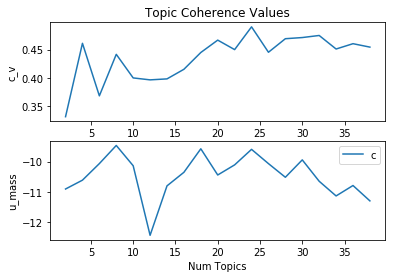

In [29]:
# Show graph
import matplotlib.pyplot as plt
limit=39; start=2; step=2;
x = range(start, limit, step)

plt.subplot(2, 1, 1)
plt.plot(x, coherence_values,label="c_v")
plt.title('Topic Coherence Values')
plt.ylabel('c_v')

plt.subplot(2, 1, 2)
plt.plot(x, coherence_values2,label="u_mass")
plt.xlabel('Num Topics')
plt.ylabel('u_mass')

plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Set parameters.
num_topics = 8
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

# Print the Keyword in the topics
print(lda_model.print_topics())

"""
# Compute Coherence Score using c_v and UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda_cv = coherence_model_lda.get_coherence()
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
print('\nCoherence Score_c_v: ', coherence_lda_cv)
print('\nCoherence Score_umass: ', coherence_lda_umass)
"""

[(0, '0.036*"video_video" + 0.035*"video" + 0.016*"mariage" + 0.014*"nouvelle" + 0.012*"après" + 0.012*"photo" + 0.011*"vidéo" + 0.011*"nouveau" + 0.011*"maison" + 0.010*"faire"'), (1, '0.038*"immobilier" + 0.019*"paris" + 0.013*"johnny_hallyday" + 0.013*"tirage" + 0.012*"hallyday" + 0.012*"article" + 0.012*"vente" + 0.011*"contre" + 0.010*"leurs" + 0.010*"johnny"'), (2, '0.052*"meilleure_réponse" + 0.022*"résolu_forum" + 0.019*"réponse" + 0.019*"meilleure" + 0.019*"forum" + 0.018*"affich" + 0.015*"résolu" + 0.015*"comment" + 0.013*"forum_affich" + 0.010*"ticketac_spectacle"'), (3, '0.047*"meteo" + 0.032*"etudiant_etudiant" + 0.027*"etudiant" + 0.023*"chaîne_météo" + 0.022*"ville_prevision" + 0.017*"gratuite_jours" + 0.017*"prévisions_meteo" + 0.017*"latitude_altitude" + 0.013*"météo" + 0.013*"chaîne"'), (4, '0.032*"sport" + 0.020*"immobilier_article" + 0.018*"temp_sport" + 0.016*"temp" + 0.015*"monde" + 0.013*"image_sport" + 0.013*"traités_rédaction" + 0.013*"suivez_temp" + 0.013*"acc

'\n# Compute Coherence Score using c_v and UMass\ncoherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence=\'c_v\')\ncoherence_model_lda_umass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")\ncoherence_lda_cv = coherence_model_lda.get_coherence()\ncoherence_lda_umass = coherence_model_lda_umass.get_coherence()\nprint(\'\nCoherence Score_c_v: \', coherence_lda_cv)\nprint(\'\nCoherence Score_umass: \', coherence_lda_umass)\n'

## Improving Model: Analysing titles with LSA and Clustering

In [18]:
## LSA: https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import pandas as pd

df = pd.read_csv("data2.csv")
documents = df["title"].values
unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute","internaute","madame"]

# some preprocessing
for r in range(0,len(documents)):
    documents[r] = ''.join(i for i in documents[r] if not i.isdigit())
    
    # Removing words with less than XX characters
    XX = 4
    documents[r] = ' '.join([w for w in documents[r].split() if len(w)>XX and w not in unallowed_words])

# raw documents to tf-idf matrix: 
vectorizer = TfidfVectorizer(use_idf=True, 
                             smooth_idf=True)
# SVD to reduce dimensionality: 
svd_model = TruncatedSVD(n_components=1000,
                         algorithm='randomized',
                         n_iter=100)
# pipeline of tf-idf + SVD, fit to and applied to documents:
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(documents)
# svd_matrix can later be used to compare documents, compare words, or compare queries with documents

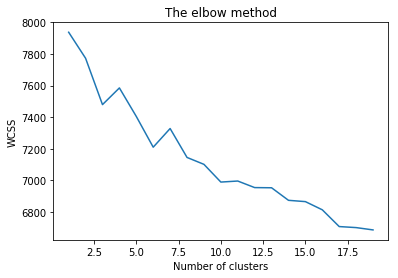

In [19]:
# Finding optimum number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

NBR_CLUSTER_TEST = 20
x = []
for j in range(0,len(svd_matrix)):
    x.append(svd_matrix[j])
wcss = [] #Within Cluster Sum of Squares

for i in range(1, NBR_CLUSTER_TEST):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, NBR_CLUSTER_TEST), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [20]:
#Applying kmeans to the dataset / Creating the kmeans classifier
BEST_CLUSTER_NBR = 7
kmeans = KMeans(n_clusters = BEST_CLUSTER_NBR, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)
df["kmeans_class"] = y_kmeans
df.groupby('kmeans_class').count() 

,Unnamed: 0,url_clean,title,description
kmeans_class,,,,
0,2019,2019,2019,2019
1,11919,11919,11919,11919
2,216,216,216,216
3,255,255,255,255
4,304,304,304,304
5,59,59,59,59
6,69,69,69,69


In [21]:
#Using LDA to find 1 topic per cluster
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import gensim
from gensim import corpora
import pickle

def preprocess(text):
    result = []
    unallowed_words = ["lefigaro","figaro","linternaute","commentcamarche","journaldunet","lachainemeteo","linternaute","internaute","madame"]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 4 and token not in unallowed_words:
            result.append(token)
    return result

CLUSTER_NUM = 7
for i in range(0,CLUSTER_NUM):
    # Latent DIrichlet Allocation Model
    processed_desc = df.loc[df['kmeans_class']==i]["title"].map(preprocess)
    dictionary = corpora.Dictionary(processed_desc)
    corpus = [dictionary.doc2bow(text) for text in processed_desc]

    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 1, id2word=dictionary, passes=15)
    #ldamodel.save(f"model{NUM_TOPICS}.gensim")
    for idx, topic in ldamodel.print_topics(-1):
        print('Cluster: {} \n Topic: {} \nWords: {}'.format(i, ldamodel.print_topics(num_words=1), topic))
        print()

Cluster: 0 
 Topic: [(0, '0.175*"résolu"')] 
Words: 0.175*"résolu" + 0.034*"comment" + 0.016*"congeler" + 0.012*"facebook" + 0.011*"asperges" + 0.011*"astuces" + 0.010*"santé" + 0.010*"médecine" + 0.008*"faire" + 0.007*"iphone"

Cluster: 1 
 Topic: [(0, '0.017*"recette"')] 
Words: 0.017*"recette" + 0.009*"cuisine" + 0.008*"comment" + 0.006*"facile" + 0.006*"etudiant" + 0.005*"france" + 0.004*"santé" + 0.004*"gratuit" + 0.003*"médecine" + 0.003*"paris"

Cluster: 2 
 Topic: [(0, '0.111*"conseils"')] 
Words: 0.111*"conseils" + 0.110*"santé" + 0.109*"fiches" + 0.108*"médicaux" + 0.021*"quels" + 0.018*"quelles" + 0.010*"comment" + 0.010*"causes" + 0.008*"douleur" + 0.008*"symptômes"

Cluster: 3 
 Topic: [(0, '0.167*"meteo"')] 
Words: 0.167*"meteo" + 0.104*"météo" + 0.091*"chaîne" + 0.090*"jours" + 0.090*"gratuite" + 0.084*"prévisions" + 0.014*"france" + 0.013*"espagne" + 0.007*"italie" + 0.006*"meilleure"

Cluster: 4 
 Topic: [(0, '0.250*"sport"')] 
Words: 0.250*"sport" + 0.250*"temps" + 0.

## Improving Model: Analysing Descriptions with Word2vec and Clustering

In [22]:
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

model_w2v_path = './model_w2v_urls.bin'
df2 = pd.read_csv("data2.csv")
X_train = df2["description"]
emb_size = 128

# some preprocessing
XX = 4
for r in range(0,len(X_train)):
    X_train[r] = ''.join(i for i in X_train[r] if not i.isdigit())
    X_train[r] = ' '.join([w for w in X_train[r].split() if len(w)>XX])

In [23]:
# Building/training the model
# Initialize model_w2v and build vocabularies
# should use the whole dataset, not just training set
model_w2v = Word2Vec(size=emb_size, min_count=5)
model_w2v.build_vocab(X_train)
model_w2v.train(X_train, total_examples=model_w2v.corpus_count, epochs=2000)

# save the model_w2v
model_w2v.save(model_w2v_path)
print("training w2v: done")

training w2v: done


In [24]:
# Reloading the trained model_w2v, buidling vectors and cleaning dataframe
new_model = Word2Vec.load(model_w2v_path)
X = new_model[new_model.wv.vocab] # get words

def build_word2vec_from_text(model_w2v, sentence, emb_size):
    emb_vec = np.zeros(emb_size).reshape((1, emb_size))
    count = 0.
    for word in sentence:
        try:
            emb_vec += model_w2v[word].reshape((1, emb_size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        emb_vec /= count
    return emb_vec

def scalar_2vec(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

X_train = np.concatenate([build_word2vec_from_text(new_model, d, emb_size) for d in X_train]) #model_w2v
newdf = pd.concat([df2, pd.DataFrame(X_train)],  axis=1)
newdf["vect"] = newdf[list(range(0,128))].values.tolist()
selected_columns = ["url_clean","title","description","vect"]
newdf = scalar_2vec(newdf, selected_columns)
newdf.head()

,url_clean,title,description,vect
0,"['droit', 'finances', 'commentcamarche', 'foru...",Ne pas déclarer ses revenus à pôle emploi [Rés...,Meilleure réponse: Bonsoir; déclaration mensue...,"[-0.1136326690018177, -0.01917192471878869, 0...."
1,"['cuisine', 'journaldesfemmes', 'recette', 'de...",Recettes de desserts faciles et rapides,meilleures recettes desserts; classiques origi...,"[-0.06005799306763543, -0.010649692888061205, ..."
2,"['droit', 'finances', 'commentcamarche', 'faq'...",Salaire d'une assistante maternelle : ce qu'il...,rémunération assistantes maternelles (salaire ...,"[-0.07474714340736167, -0.05681402749861732, 0..."
3,"['lachainemeteo', 'meteo', 'france', 'ville', ...",Meteo Bordeaux (33000) - Gironde : Prévisions ...,Meteo Bordeaux jours prévision météo gratuite....,"[-0.14753458100924458, -0.04770482218135958, 0..."
4,"['droit', 'finances', 'commentcamarche', 'faq'...",AAH 2019 : montant et plafonds de ressources,montant maximum l'allocation adultes handicapé...,"[-0.10720171013640033, -0.11059364451118457, 0..."


In [25]:
# Standardizing vectors
from sklearn import preprocessing

xvect = []
for i in range(0,len(newdf["vect"])):
    xvect.append(np.array(newdf["vect"].values[0]))

"""
## tried to standardize, normalize and scale vectors, but no improvements
standardized_vect = preprocessing.scale(xvect)
normalized_vect = preprocessing.normalize(xvect, norm='l2')
scaled_vect = preprocessing.scale(xvect)
newdf["standard_vect"] = list(standardized_vect)
newdf["normal_vect"] = list(normalized_vect)
newdf["scaled_vect"] = list(scaled_vect)
"""

'\n## tried to standardize, normalize and scale vectors, but no improvements\nstandardized_vect = preprocessing.scale(xvect)\nnormalized_vect = preprocessing.normalize(xvect, norm=\'l2\')\nscaled_vect = preprocessing.scale(xvect)\nnewdf["standard_vect"] = list(standardized_vect)\nnewdf["normal_vect"] = list(normalized_vect)\nnewdf["scaled_vect"] = list(scaled_vect)\n'

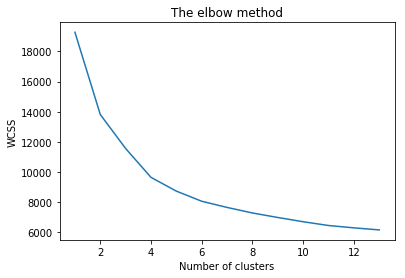

In [26]:
# Finding optimum number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

NBR_CLUSTER_TEST = 14
x = []
for j in range(0,len(newdf)):
    x.append(newdf["vect"][j])
wcss = [] #Within Cluster Sum of Squares

for i in range(1, NBR_CLUSTER_TEST):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, NBR_CLUSTER_TEST), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [27]:
#Applying kmeans to the dataset / Creating the kmeans classifier
BEST_CLUSTER_NBR = 10
kmeans = KMeans(n_clusters = BEST_CLUSTER_NBR, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)
newdf["kmeans_class"] = y_kmeans
newdf.groupby('kmeans_class').count()

,url_clean,title,description,vect
kmeans_class,,,,
0,1819,1819,1819,1819
1,3690,3690,3690,3690
2,284,284,284,284
3,375,375,375,375
4,4634,4634,4634,4634
5,5,5,5,5
6,31,31,31,31
7,720,720,720,720
8,925,925,925,925


LDA FAILED FOR CLUSTER: 0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-a627d21e9f3a>", line 41, in <module>
    word2_matrix = pd.concat([word2_matrix, pd.Series(tfidf_matrix.getrow(rows).toarray().flatten(),index = features).sort_values(ascending=False)])
  File "/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/reshape/concat.py", line 225, in concat
    copy=copy, sort=sort)
  File "/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/reshape/concat.py", line 378, in __init__
    self.new_axes = self._get_new_axes()
  File "/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/reshape/concat.py", line 458, in _get_new_axes
    new_axes[self.axis] = self._get_concat_axis()
  File "/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/reshape

KeyboardInterrupt: 

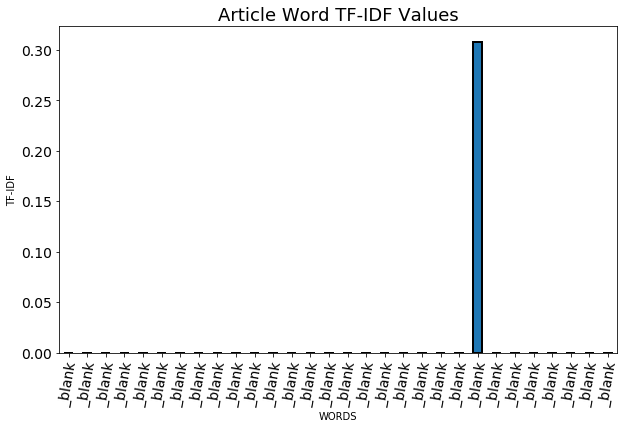

In [28]:
#TF-IDF Analysis
#We want to plot the number of words of description text for each cluster
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import gensim
from gensim import corpora
import pickle

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

CLUSTER_NUM = 8
for i in range(0,CLUSTER_NUM):
    #TfidfVectorizer: Converts a collection of raw documents to a matrix of TF-IDF features.
    #min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
    #max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.
    #Apply this vectorizer to the full dataset to create normalized vectors
    tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df = 0.95, sublinear_tf=True, use_idf=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(newdf["description"].values)

    #tfidf_vectorizer.get_feature_names(): Array mapping from feature integer indices to feature name
    features = tfidf_vectorizer.get_feature_names()

    #Get the row that belongs to cluster 0
    row = newdf.loc[newdf['kmeans_class']==i].index.tolist()
    
    """
    #Create a series from the sparse matrix
    word2_matrix = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(),index = features).sort_values(ascending=False)
    """
    
    word2_matrix = pd.Series()
    for rows in row:
        word2_matrix = pd.concat([word2_matrix, pd.Series(tfidf_matrix.getrow(rows).toarray().flatten(),index = features).sort_values(ascending=False)])
    word2_matrix = word2_matrix.sort_index(axis=0)
    
    tf_idf_plot = word2_matrix[:30].plot(kind='bar', title='Article Word TF-IDF Values',
                figsize=(10,6), alpha=1, fontsize=14, rot=80,edgecolor='black', linewidth=2 )
    tf_idf_plot.title.set_size(18)
    tf_idf_plot.set_xlabel('WORDS')
    tf_idf_plot.set_ylabel('TF-IDF')
    
    # Latent Dirichlet Allocation Model
    processed_desc = word2_matrix[0:1000].index.map(preprocess)
    dictionary = corpora.Dictionary(processed_desc)
    corpus = [dictionary.doc2bow(text) for text in processed_desc]

    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')

    try:
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 1, id2word=dictionary, passes=15)
        #ldamodel.save(f"model{NUM_TOPICS}.gensim")
        for idx, topic in ldamodel.print_topics(-1):
            print('dataframe: {} \n topic: {} \n Words: {}'.format(i, idx, topic))
    except:
        print(f"LDA FAILED FOR CLUSTER: {i}")